# A Study of Feature Importance in the Forest Cover Type Prediction Dataset


Data source: https://www.kaggle.com/c/forest-cover-type-prediction

In [186]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import cross_validation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif 

%matplotlib inline

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## Load Data

In [191]:
forest = pd.read_csv("data/train.csv") 
forest = forest.iloc[:,1:]

In [192]:
forest.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

# Feature Engineering

In [193]:
def labelSoilType(row):
    """
    Label soil types
    """
    for i in range(len(row)):
        if row[i] == 1:
            return 'Soil_Type'+str(i)
        
def azimuth_to_abs(x):
    """
    Only care about the absolute angle from 0 w/o respect to direction
    """
    if x>180:
        return 360-x
    else:
        return x

In [194]:
# Create Soil Type Buckets
soil_types = pd.read_csv('soil_types.csv').set_index('Soil Type')
forest['Soil Type'] = forest[['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']].apply(lambda row: labelSoilType(row), axis=1)
forest = pd.merge(forest, soil_types, how='left', left_on='Soil Type', right_index=True)
del forest['Soil Type'] # Delete string column

# Create feature to that transforms azimuth to its absolute value
forest['Aspect2'] = forest.Aspect.map(azimuth_to_abs)
forest['Aspect2'].astype(int)

# Create feature that determines if the patch is above sea level
forest['Above_Sealevel'] = (forest.Vertical_Distance_To_Hydrology>0).astype(int)

# Bin the Elevation Feature: check the feature exploration notebook for motivation
bins = [0, 2600, 3100, 8000]
group_names = [1, 2, 3]
forest['Elevation_Bucket'] = pd.cut(forest['Elevation'], bins, labels=group_names)
forest['Elevation_0_2600'] = np.where(forest['Elevation_Bucket']== 1, 1, 0)
forest['Elevation_2600_3100'] = np.where(forest['Elevation_Bucket']== 2, 1, 0)
forest['Elevation_3100_8000'] = np.where(forest['Elevation_Bucket']== 3, 1, 0)
forest['Elevation_0_2600'].astype(int)
forest['Elevation_2600_3100'].astype(int)
forest['Elevation_3100_8000'].astype(int)
del forest['Elevation_Bucket']

# Create a feature for no hillshade at 3pm
forest['3PM_0_Hillshade'] = (forest.Hillshade_3pm == 0).astype(int)

#Direct distance to hydrology
forest['Direct_Distance_To_Hydrology'] = np.sqrt((forest.Vertical_Distance_To_Hydrology**2) + \
    (forest.Horizontal_Distance_To_Hydrology**2)).astype(float).round(2)


soil_types= ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40', 'Cover_Type']

column_list = forest.columns.tolist()
column_list = [c for c in column_list if c[:9] != 'Soil_Type']
column_list.insert(10, 'Direct_Distance_To_Hydrology')
column_list.insert(11, 'Elevation_0_2600')
column_list.insert(12, 'Elevation_2600_3100')
column_list.insert(13, 'Elevation_3100_8000')
column_list.insert(14, 'Aspect2')
column_list.insert(15, 'Above_Sealevel')
column_list.insert(16, '3PM_0_Hillshade')
column_list.extend(soil_types)
columns = []
for col in column_list:
    if col not in columns:
        if col != 'Cover_Type':
            columns.append(col)
columns.append('Cover_Type')
        

forest = forest[columns]
forest.fillna(0,inplace=True) # Replace nans with 0 for our soil type bins
forest.shape

(15120, 99)

## Remove Base Features with no Modeling Value

In [196]:
to_remove = [] # features to drop
for c in forest.columns.tolist():
    if forest[c].std() == 0:
        to_remove.append(c)
forest = forest.drop(to_remove, 1)
print("Dropped the following columns: \n")
for r in to_remove:
    print (r)

Dropped the following columns: 

Wetmore
Pachic Argiborolis
Aquolis


## Add Feature Interactions

In [197]:
for i in range(forest.shape[1]-1):
    for j in range(54):
        if i != j:
            forest[forest.columns.tolist()[i]+"_"+forest.columns.tolist()[j]] = forest[forest.columns.tolist()[i]]*forest[forest.columns.tolist()[j]]

## Remove Columns That Have No Value

In [198]:
to_remove = [] # features to drop
for c in forest.columns.tolist():
    if forest[c].std() == 0:
        to_remove.append(c)
forest = forest.drop(to_remove, 1)
print("Dropped the following columns: \n")
for r in to_remove:
    print (r)

Dropped the following columns: 

Hillshade_3pm_3PM_0_Hillshade
Elevation_0_2600_Elevation_2600_3100
Elevation_0_2600_Elevation_3100_8000
Elevation_0_2600_Wilderness_Area2
Elevation_0_2600_Cryumbrepts 
Elevation_0_2600_Bross
Elevation_0_2600_Cryorthents
Elevation_0_2600_Granile
Elevation_0_2600_Moran
Elevation_0_2600_Gothic
Elevation_0_2600_Rogert
Elevation_2600_3100_Elevation_0_2600
Elevation_2600_3100_Elevation_3100_8000
Elevation_2600_3100_Cryumbrepts 
Elevation_2600_3100_Bross
Elevation_2600_3100_Cryorthents
Elevation_3100_8000_Elevation_0_2600
Elevation_3100_8000_Elevation_2600_3100
Elevation_3100_8000_Wilderness_Area4
Elevation_3100_8000_Rubbly
Elevation_3100_8000_Warm
Elevation_3100_8000_Cathedral
Elevation_3100_8000_Vanet
Elevation_3100_8000_Ratake
Elevation_3100_8000_Haploborolis
Elevation_3100_8000_Gothic
Elevation_3100_8000_Limber
Elevation_3100_8000_Troutville
Elevation_3100_8000_Bullwark
Elevation_3100_8000_Cryoborolis
Elevation_3100_8000_Gateview
Above_Sealevel_Gothic
3PM_

# Limit to top 100 features

In [203]:
top100 = pd.read_csv('top_100.csv', header=None, names=['Feature', 'Importance'])
forest = forest[list(top100['Feature'].values)]
forest.shape

(15120, 100)

### Transform the continuous features
###### We will try Normalization, Standardized Scaling, and MinMax Scaling
###### Note: there is no need to impute any data points as this is a pretty clean data set

In [204]:
num_rows, num_cols = forest.shape
cols = forest.columns

chunk_size = 0.1 #Validation chunk size
size = 10 # First categorical column
seed = 0 # Use the same random seed to ensure consistent validation chunk usage

ranks = [] #array of importance rank of all features
X_all = [] # all features
X_all_add = [] # Additionally we will make a list of subsets
rem = [] # columns to be dropped
i_rem = [] # indexes of columns to be dropped
trans_list = [] # Transformations
comb = [] # combinations
comb.append("All+1.0")

ratio_list = [1.0, 0.75,0.50,0.25] #Select top 100%, 75%, 50%, 25% of features
features = [] # feature selection models
model_features = [] # names of feature selection models

i_cols = []
for i in range(0,num_cols-1):
    i_cols.append(i)

val_array = forest.values
X = val_array[:,0:(num_cols-1)]
y = val_array[:,(num_cols-1)]
X_train, X_val, y_train, y_val = cross_validation.train_test_split(X, y, test_size=chunk_size, random_state=seed)
X_all.append(['Orig','All', X_train,X_val,1.0,cols[:num_cols-1],rem,ranks,i_cols,i_rem])

In [205]:
# Standardize the data

X_temp = StandardScaler().fit_transform(X_train[:,0:size])
X_val_temp = StandardScaler().fit_transform(X_val[:,0:size])

# Recombine data
X_con = np.concatenate((X_temp,X_train[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val[:,size:]),axis=1)

X_all.append(['StdSca','All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

In [206]:
# MinMax Scale the data

X_temp = MinMaxScaler().fit_transform(X_train[:,0:size])
X_val_temp = MinMaxScaler().fit_transform(X_val[:,0:size])

# Recombine data
X_con = np.concatenate((X_temp,X_train[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val[:,size:]),axis=1)

X_all.append(['MinMax', 'All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

In [207]:
#Normalize the data

X_temp = Normalizer().fit_transform(X_train[:,0:size])
X_val_temp = Normalizer().fit_transform(X_val[:,0:size])

# Recombine data
X_con = np.concatenate((X_temp,X_train[:,size:]),axis=1)
X_val_con = np.concatenate((X_val_temp,X_val[:,size:]),axis=1)

X_all.append(['Norm', 'All', X_con,X_val_con,1.0,cols,rem,ranks,i_cols,i_rem])

In [208]:
# Add transformation to the list
for trans,name,X,X_val,v,cols_list,rem_list,rank_list,i_cols_list,i_rem_list in X_all:
    trans_list.append(trans)

### Create classifiers
- Extra Trees Classifier
- Gradient Boosting Classifier
- Random Forest Classifier
- XGBoost Classifier
- Random Feature Elimination Classifier

In [209]:
# Add Extra Trees Classifier
n = 'Extra Trees Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,ExtraTreesClassifier(n_estimators=num_cols-1,max_features=val,n_jobs=-1,random_state=seed)])      

# Add Gradient Boosting Classifier
n = 'Gradient Boosting Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,GradientBoostingClassifier(n_estimators=num_cols-1,max_features=val,random_state=seed)])   

# Add Random Forest Classifiers
n = 'Random Forest Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,RandomForestClassifier(n_estimators=num_cols-1,max_features=val,n_jobs=-1,random_state=seed)])   

# Add XGBoost Classifier
n = 'XGBoost Classifier'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,XGBClassifier(n_estimators=num_cols-1,seed=seed)])   

# Add RFE
model = LogisticRegression(random_state=seed,n_jobs=-1)
n = 'Random Feature Elimination'
model_features.append(n)
for val in ratio_list:
    comb.append("%s+%s" % (n,val))
    features.append([n,val,RFE(model,val*(num_cols-1))])

### Run models on selected features

In [ ]:
# Determine feature importance for each model and transformation combination
for trans, s, X, X_val, d, cols, rem, ra, i_cols, i_rem in X_all:
    for name,v,model in features:
        print (name)
        print (v)
        print (model)
        # Combine importance and index of the column in the array joined
        joined = []
        for i, imp in enumerate(list(top100.values)):
            joined.append([i, imp[0], imp[1]])

        cols_list = [] # List of names of columns selected
        i_cols_list = [] # Indexes of columns selected
        rank_list =[] # Ranking of all the columns
        rem_list = [] # List of columns not selected
        i_rem_list = [] # Indexes of columns not selected

        rem_start = int((v*(num_cols-1))) # Starting point of the columns to be dropped

        # Split the array. Store selected columns in cols_list and removed in rem_list
        for j, (i, col, x) in enumerate(list(joined)):
            rank_list.append([i,j])
            if(j < rem_start):
                cols_list.append(col)
                i_cols_list.append(i)   
            else:
                rem_list.append(col)
                i_rem_list.append(i)
        #Limit training and validation dataset to just relevant columns
        X_new = np.delete(X, i_rem_list, axis=1)
        X_val_new = np.delete(X_val, i_rem_list, axis=1)
        
        #Fit the model on selected dataset
        model.fit(X_new, y_train)
        
        #Calculate model score against true class for each sample
        print (model.score(X_val_new, y_val))
        print ('')
        print ('----------------')
        print ('')
        
        # Sort the rank_list and store only the ranks. Drop the index 
        # Append model name, array, columns selected and columns to be removed to the additional list        
        X_all_add.append([trans,name,X_new,X_val_new,v,cols_list,rem_list,[x[1] for x in sorted(rank_list,key=lambda x:x[0])],i_cols_list,i_rem_list])    

Extra Trees Classifier
0.75
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.75, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=99, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
0.953703703704

----------------

Extra Trees Classifier
0.5
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.5, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=99, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
0.719576719577

----------------

Extra Trees Classifier
0.25
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, ma

### Plot the results

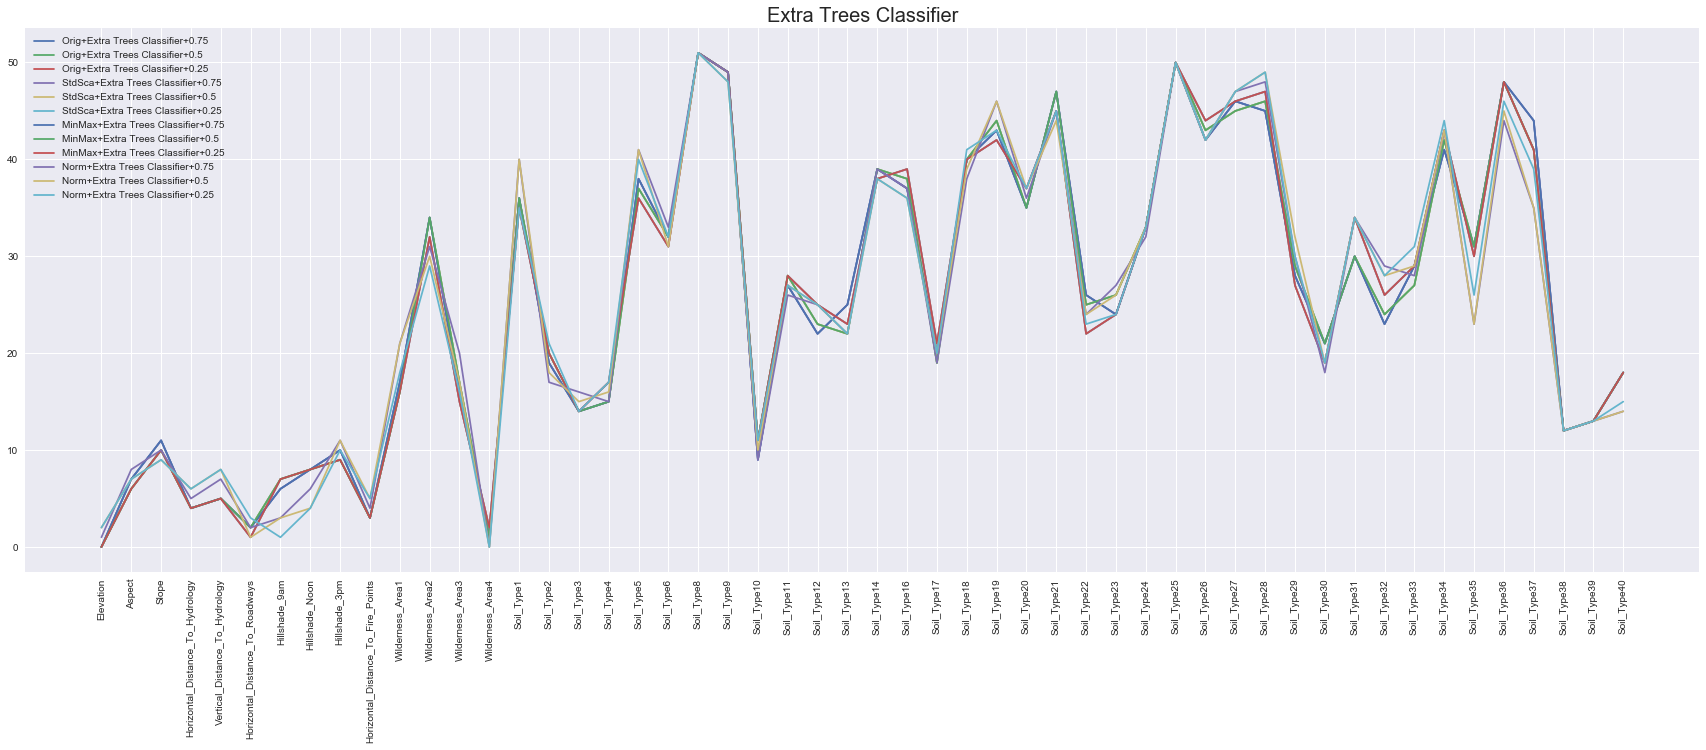

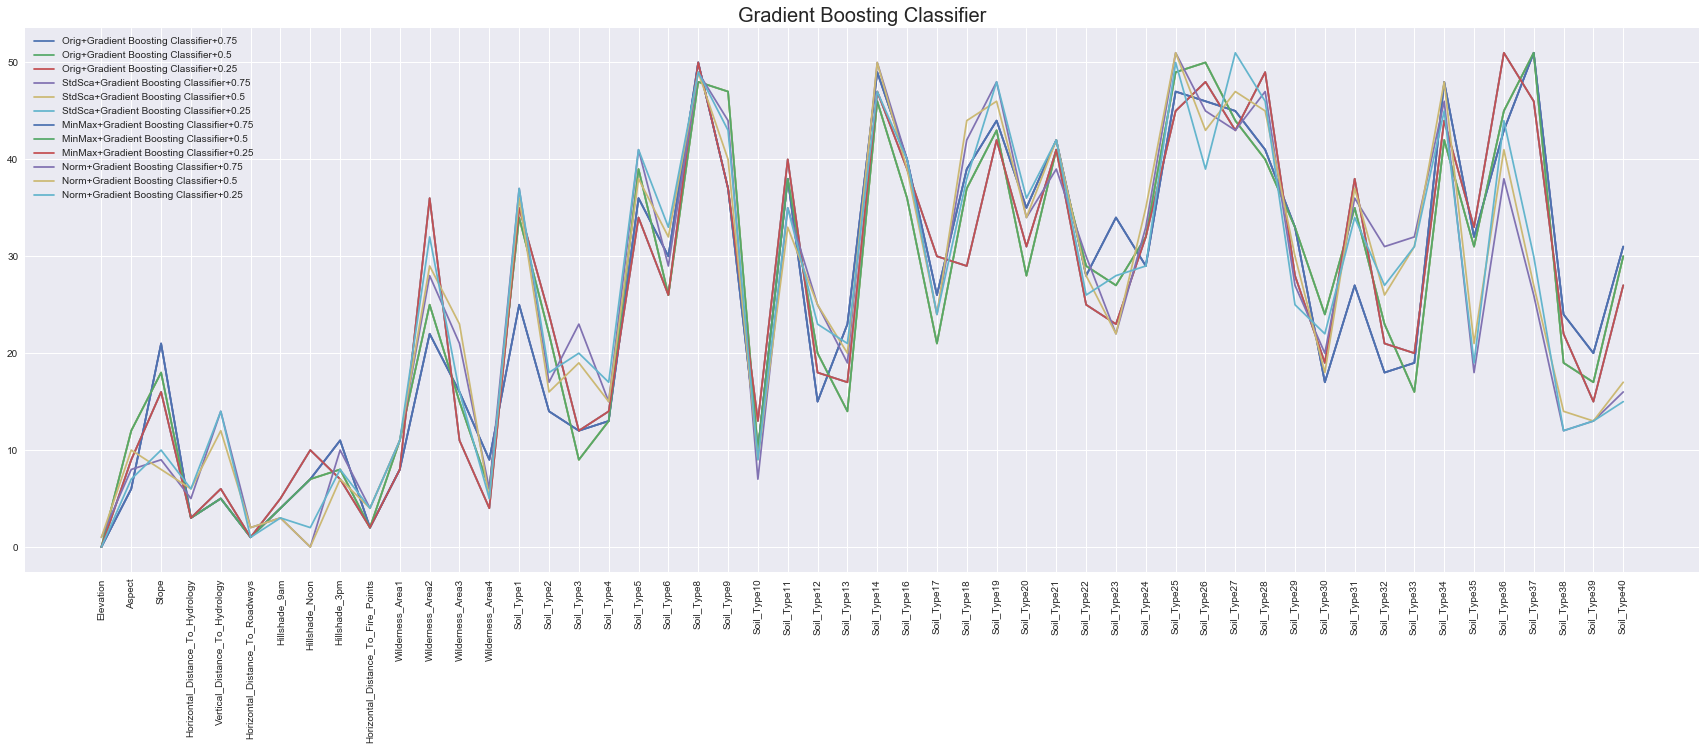

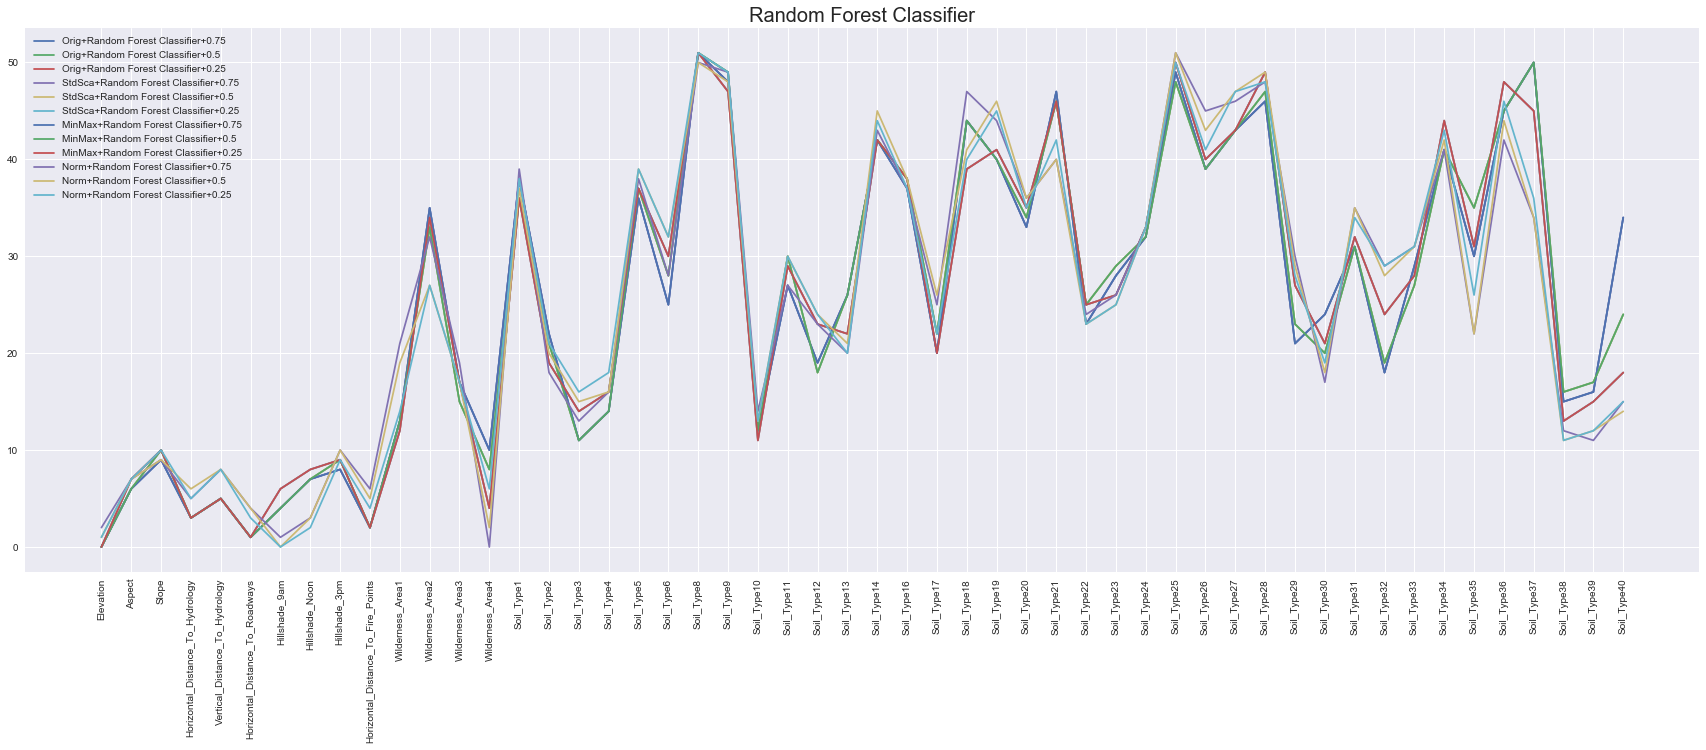

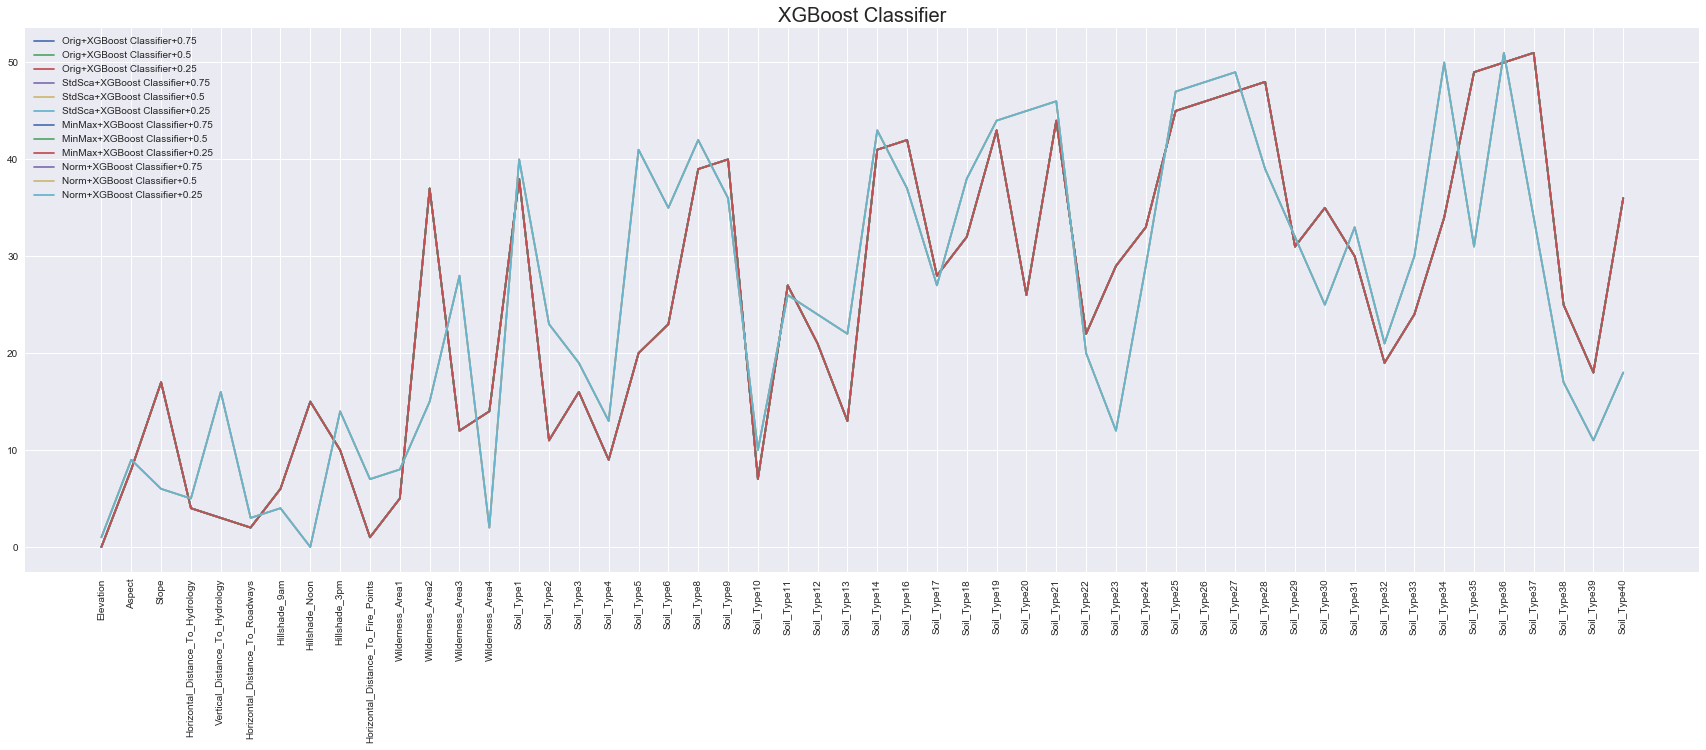

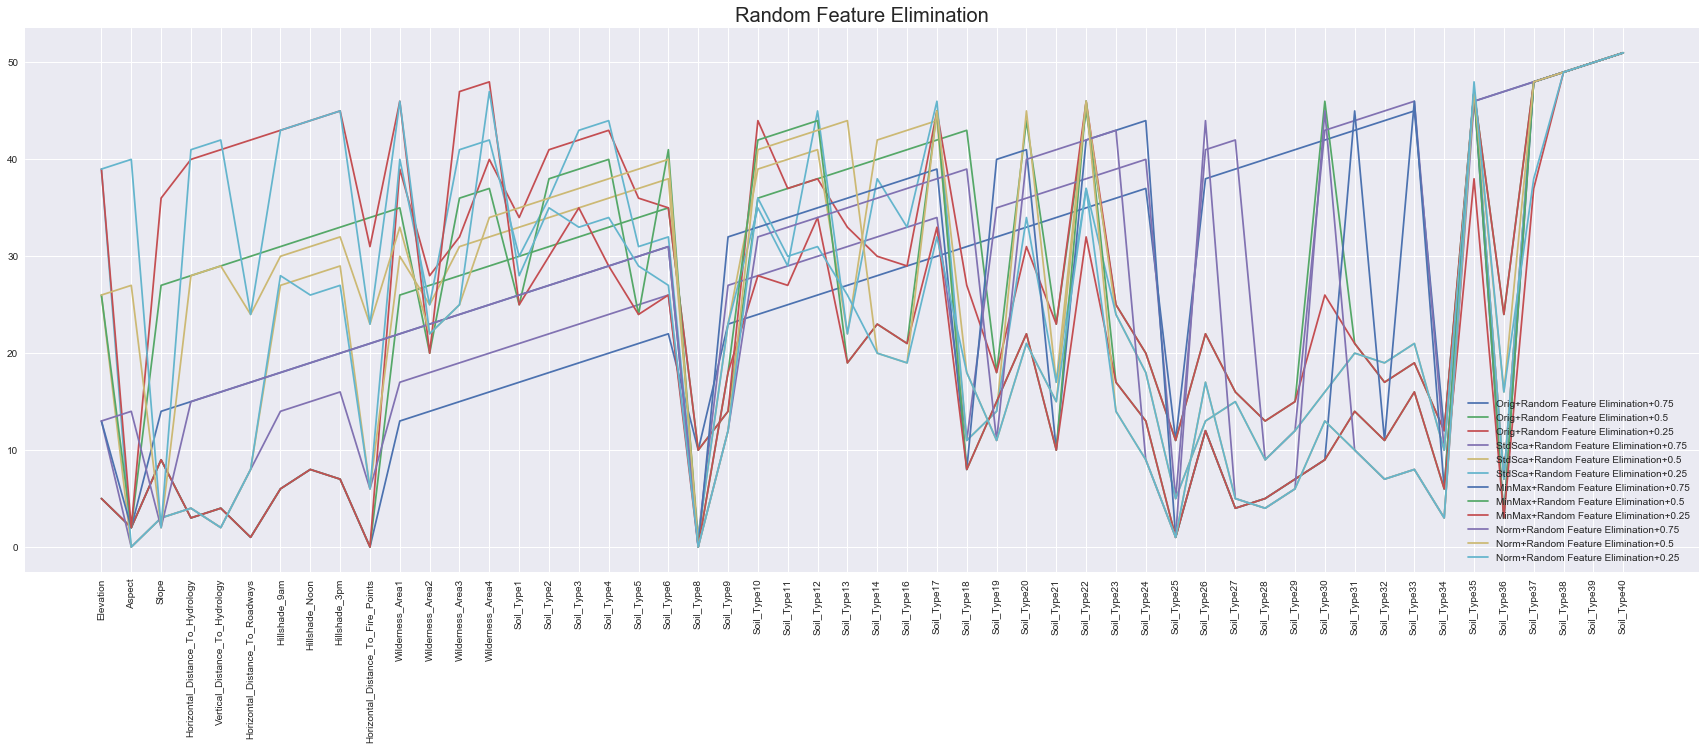

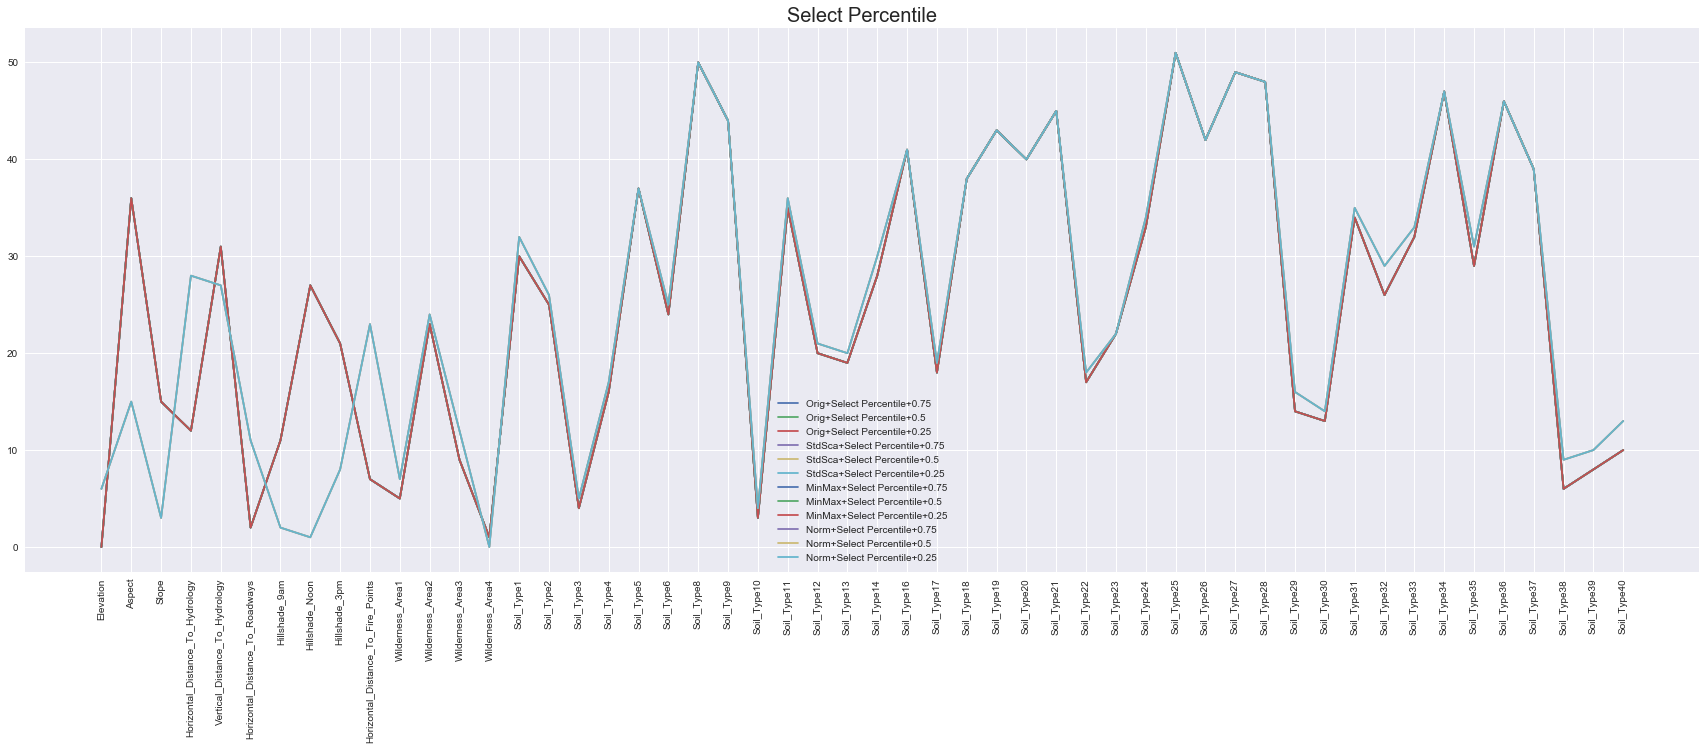

In [10]:
#Set figure size
plt.rc("figure", figsize=(30, 10))

#Plot a graph for different feature selectors        
for f_name in model_features:
    #Array to store the list of combinations
    leg=[]
    fig, ax = plt.subplots()
    #Plot each combination
    for trans,name,X,X_val,v,cols_list,rem_list,rank_list,i_cols_list,i_rem_list in X_all_add:
        if(name==f_name):
            plt.plot(rank_list)
            leg.append(trans+"+"+name+"+%s"% v)
            plt.title(name,size=20)
    #Set the tick names to names of columns
    ax.set_xticks(range(num_cols-1))
    ax.set_xticklabels(cols[:num_cols-1],rotation='vertical')
    #Display the plot
    plt.legend(leg,loc='best')    
    #Plot the rankings of all the features for all combinations
    plt.show()

## Select the Important Features

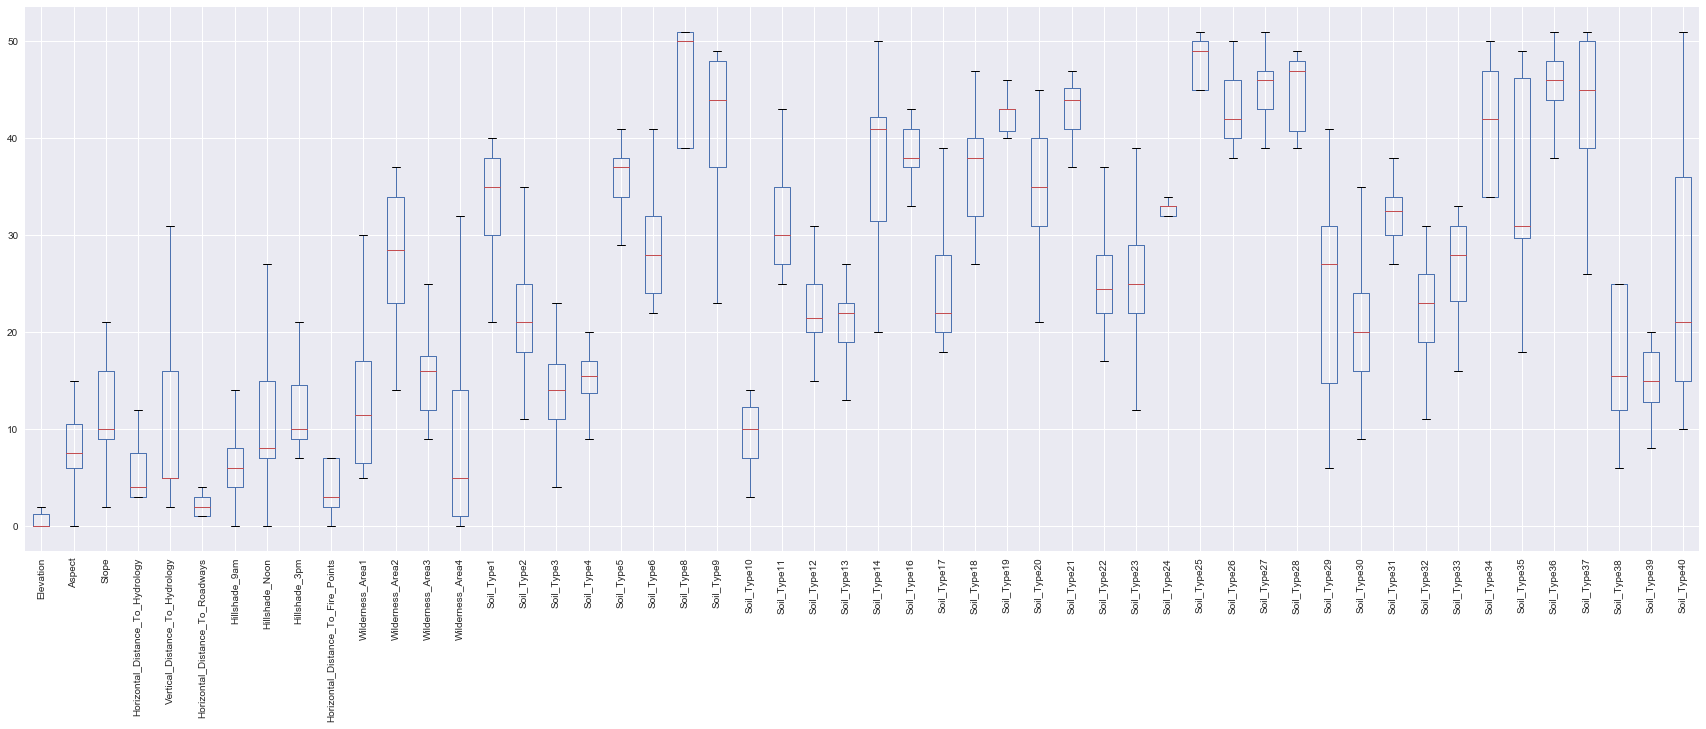

In [11]:
rank_df = pd.DataFrame(data=[x[7] for x in X_all_add],columns=cols[:num_cols-1])
rank_df.boxplot(rot=90);

In [12]:
rank_df = pd.DataFrame(data=[x[7] for x in X_all_add],columns=cols[:num_cols-1])
med = rank_df.median()
med.sort()
med

Elevation                              0.0
Horizontal_Distance_To_Roadways        2.0
Horizontal_Distance_To_Fire_Points     3.0
Horizontal_Distance_To_Hydrology       4.0
Vertical_Distance_To_Hydrology         5.0
Wilderness_Area4                       5.0
Hillshade_9am                          6.0
Aspect                                 7.5
Hillshade_Noon                         8.0
Hillshade_3pm                         10.0
Slope                                 10.0
Soil_Type10                           10.0
Wilderness_Area1                      11.5
Soil_Type3                            14.0
Soil_Type39                           15.0
Soil_Type4                            15.5
Soil_Type38                           15.5
Wilderness_Area3                      16.0
Soil_Type30                           20.0
Soil_Type40                           21.0
Soil_Type2                            21.0
Soil_Type12                           21.5
Soil_Type13                           22.0
Soil_Type17